In [81]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from collections import Counter

## Image Count by Waste Categories (Before oversample/duplicate)

Images are collected from DrinkingWaste Dataset, Taco dataset, TrashNet, and Google Image Webscrape. Images dataset after being collected and combined is imbalanced (see the chart below).
* bio images count is significantly low
* metals and plastics becomes the majority class

Imbalanced dataset can cause biased prediction when training the model => Model is most likely to predict the item to be the majority class

Text(0.5, 1.0, 'Image Count by Waste Categories (Before oversampling)')

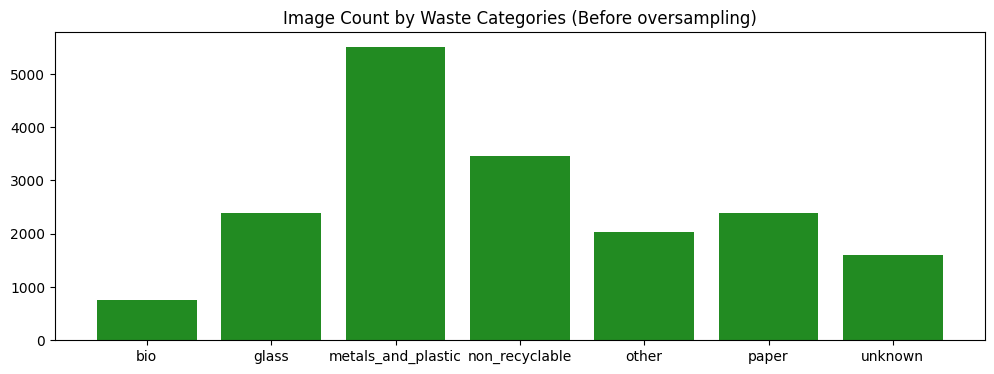

In [136]:
image_folder = './collected-datasets/All/'
labels = os.listdir(image_folder)
dictionary = {}
for label in labels:
    # concat the parent folder and the category folder
    path = '/'.join([image_folder, label])

    # count the number of images inside the folder and save the category & image count in the dictionary
    count = len(os.listdir(path))
    dictionary[label] = count

# plot
plt.figure(figsize=(12,4))
categories = dictionary.keys()
counts = dictionary.values()
plt.bar(categories, counts, color="#228B22")
plt.title('Image Count by Waste Categories (Before oversampling)')

## Image Count by Waste Categories(After oversampling)

Here, we duplicate images in the categories that have less number of images:
* bio: x5
* glass: x2
* metals_and_plastic: x1
* non recyclable: x1
* other: x2
* paper: x2
* unknown: x2

The dataset now is more balanced (see the distribution chart below)

Text(0.5, 1.0, 'Image Count by Waste Categories (After oversampling)')

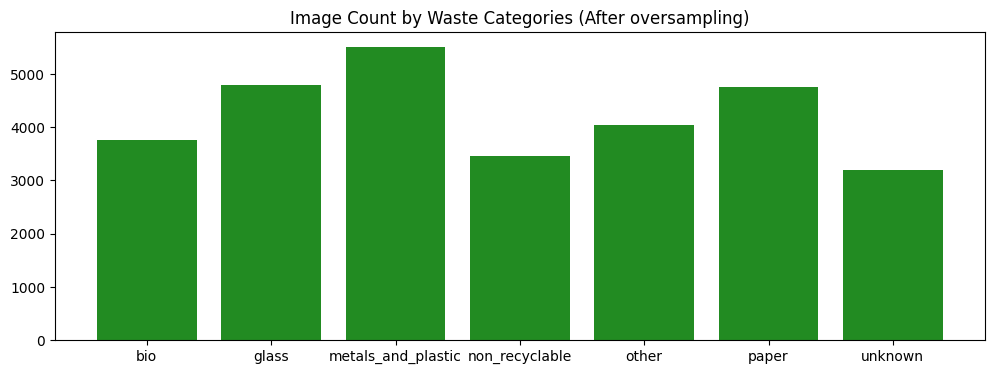

In [137]:
image_folder = './collected-datasets/All_Oversample/'
labels = os.listdir(image_folder)
dictionary = {}
for label in labels:
    # concat the parent folder and the category folder
    path = '/'.join([image_folder, label])

    # count the number of images inside the folder and save the category & image count in the dictionary
    count = len(os.listdir(path))
    dictionary[label] = count

# plot
plt.figure(figsize=(12,4))
categories = dictionary.keys()
counts = dictionary.values()
plt.bar(categories, counts, color="#228B22")
plt.title('Image Count by Waste Categories (After oversampling)')

## Image Size 

In the following block of code, we open the All_Oversample dataset and obtain the original image size of each image.
Save the image size in a csv file

In [138]:
image_folder = './collected-datasets/All_Oversample'
labels = os.listdir(image_folder)
if ' 224' in labels: 
    labels.remove(' 224')

images = []
for label in labels:
    # train
    path = '/'.join([image_folder, label])
    images.extend(['/'.join([path, f]) for f in os.listdir(path)])

widths = []
heights = []
for image in images:
    image_np = np.array(Image.open(image))
    widths.append(image_np.shape[1])
    heights.append(image_np.shape[0])

pd.DataFrame(widths).to_csv("./images_width.csv", index=False)
pd.DataFrame(heights).to_csv("./images_height.csv", index=False)

KeyboardInterrupt: 

In [29]:
def remove_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    filtered_data = [x for x in data if (x >= lower_bound) and (x <= upper_bound)]
    return filtered_data

The charts below show that images collected are in a diverse range of size (pixel count)

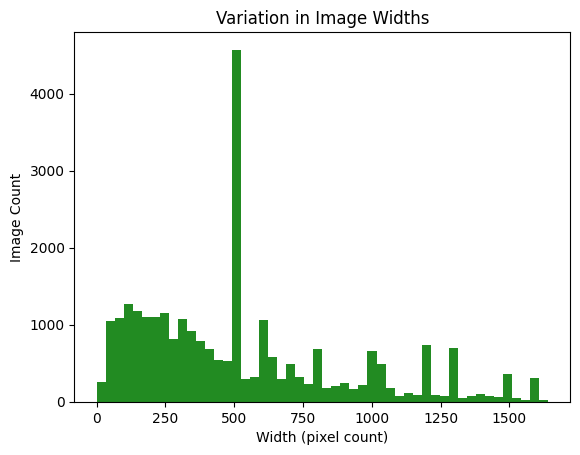

In [139]:
data = pd.read_csv("./images_width.csv").iloc[:, 0].to_numpy()
data = remove_outliers(data)

# plot
plt.hist(data, bins=50, color="#228B22")
plt.xlabel("Width (pixel count)")
plt.ylabel("Image Count")
plt.title("Variation in Image Widths")
plt.show()

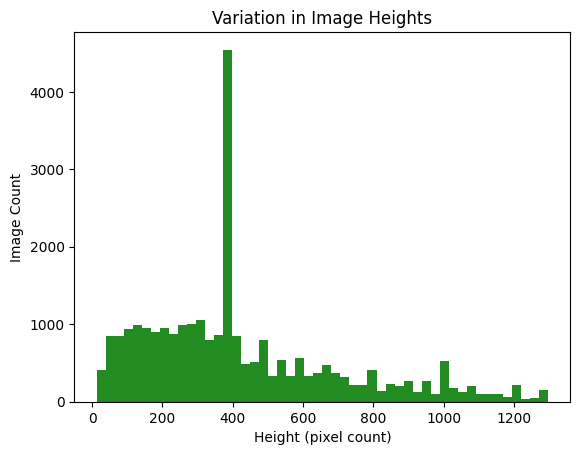

In [40]:
data = pd.read_csv("./images_height.csv").iloc[:, 0].to_numpy()
data = remove_outliers(data)

# plot
plt.hist(data, bins=50, color="#228B22")
plt.xlabel("Height (pixel count)")
plt.ylabel("Image Count")
plt.title("Variation in Image Heights")
plt.show()

# Waste Images are transformed to a uniform size (224x224) 

Since our model only accepts images of 224x224, we resize the images in our dataset. For larger images, we scale the images to 224x224. For smaller images, we pad zero to the four sides (zero-padding).

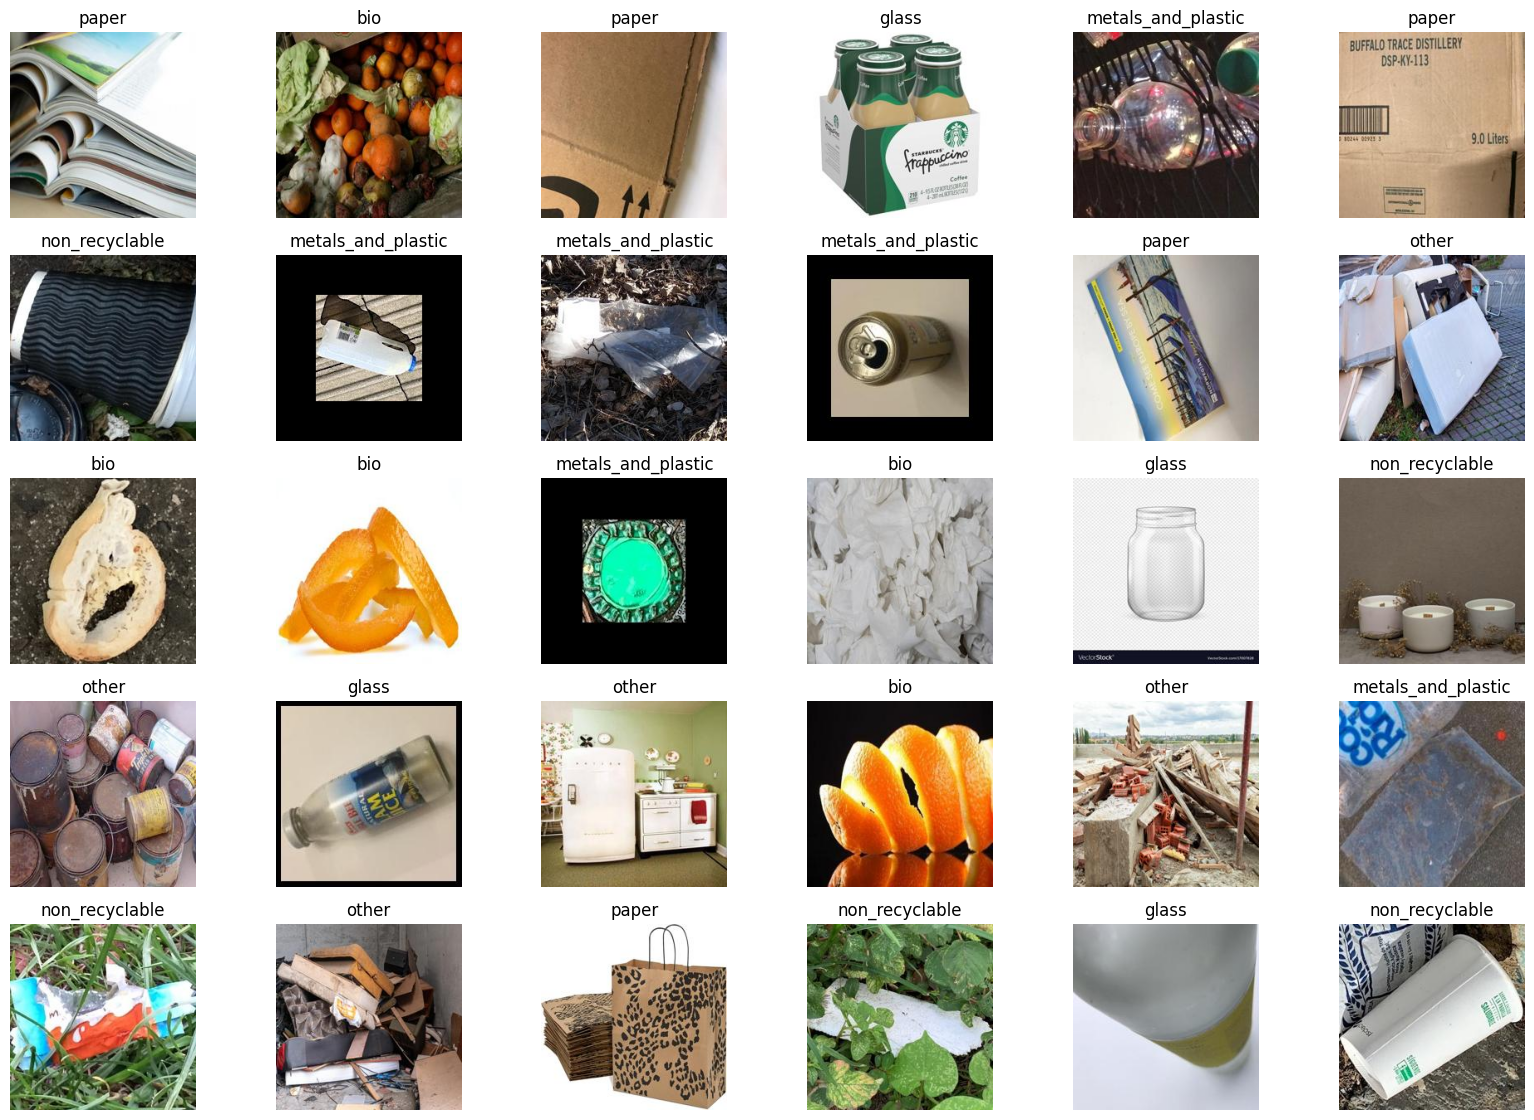

In [142]:
image_folder = './collected-datasets/train'
labels = os.listdir(image_folder)

# collect all images
images = []
for label in labels:
    if ('.' in label or 'unknown' in label):
        continue
    # train
    path = '/'.join([image_folder, label])
    images.extend(['/'.join([path, f]) for f in os.listdir(path)])

# randomly select 30 images to display
thirty_images = np.random.choice(images, 30, replace=True)

# show images
plt.figure(figsize=(20, 14))
for i, image_path in enumerate(thirty_images):
    np_image = np.array(Image.open(image_path))
    ax = plt.subplot(5, 6, i+1)
    ax.imshow(np_image)
    # ax.set_title(image_path.split('/')[-2]+'\n('+image_path.split('/')[-1].split('.')[0]+')')
    ax.set_title(image_path.split('/')[-2])
    ax.axis('off')


## Train (80%) - Val(10%) - Test(10%) split

80% of the original images were randomly selected as the training set, 10% as validation, and 10% as the test set. To avoid data leakage, each subset from a category was split separately

In [78]:
DATASET_FOLDER = './collected-datasets/All_Oversample_224'
OUT_FOLDER = './collected-datasets'
TRAIN_FOLDER = OUT_FOLDER + '/train'
VAL_FOLDER = OUT_FOLDER + '/val'
TEST_FOLDER = OUT_FOLDER + '/test'

==== Train Distribution dataframe: ====
             Category  Image Count
0                 bio         3008
1               glass         3832
2  metals_and_plastic         4408
3      non_recyclable         2768
4               other         3240
5               paper         3808
6             unknown         2552



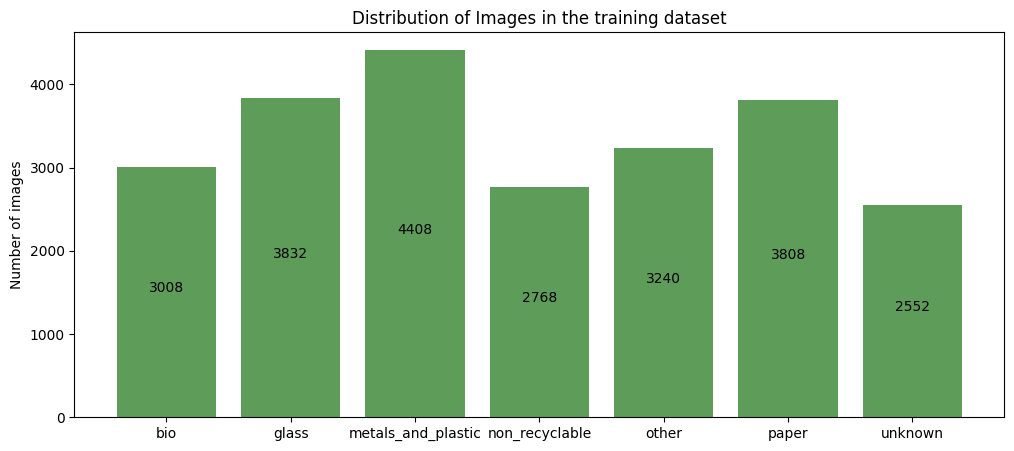

==== Validation Distribution dataframe: ====
             Category  Image Count
0                 bio          376
1               glass          479
2  metals_and_plastic          551
3      non_recyclable          346
4               other          405
5               paper          476
6             unknown          319
==== Test Distribution dataframe: ====
             Category  Image Count
0                 bio          371
1               glass          479
2  metals_and_plastic          548
3      non_recyclable          346
4               other          401
5               paper          472
6             unknown          317



In [85]:
labels = os.listdir(TRAIN_FOLDER)
train_labels = []
val_labels = []
test_labels = []
for label in labels:
    # train
    path = '/'.join([TRAIN_FOLDER, label])
    images = os.listdir(path)
    train_labels.extend([label]*len(images))
    # val
    path = '/'.join([VAL_FOLDER, label])
    images = os.listdir(path)
    val_labels.extend([label]*len(images))
    # test
    path = '/'.join([TEST_FOLDER, label])
    images = os.listdir(path)
    test_labels.extend([label]*len(images))
train_dist = pd.DataFrame(Counter(train_labels).items(), columns=['Category', 'Image Count'])
test_dist = pd.DataFrame(Counter(test_labels).items(), columns=['Category', 'Image Count'])
val_dist = pd.DataFrame(Counter(val_labels).items(), columns=['Category', 'Image Count'])
print("==== Train Distribution dataframe: ====")
print(train_dist, end='\n\n')
plt.figure(figsize=(12,5))
xs = train_dist['Category'].values
ys = train_dist['Image Count'].values
plt.bar(xs, ys, color="#5D9C59")
plt.title("Distribution of Images in the training dataset")
plt.ylabel("Number of images")
for i, x in enumerate(xs):
    plt.text(i, ys[i]//2, ys[i],ha='center')
plt.show()
print("==== Validation Distribution dataframe: ====")
print(val_dist)
print("==== Test Distribution dataframe: ====")
print(test_dist, end='\n\n')